### Import Packages

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Read file and data preprocess

In [2]:
regression_model_input_D = pd.read_csv('Data/Jacksonville/regression_model_input_D_new.csv')
regression_model_input_D.head()

,cluster,End Latitude,End Longitude,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
0,0,30.325596,-81.663067,2948,POINT (-81.66306713690477 30.32559612142857),0.0,2.0,0.0,2.0,0.0,...,0.025505,0.086128,0.012885,0.000000,0.005440,0.000000,0.000048,0.0,0.00000,0.000022
1,1,30.326925,-81.656538,1335,POINT (-81.6565384402985 30.326925479744137),0.0,0.0,1.0,4.0,6.0,...,0.019228,0.038843,0.008768,0.000009,0.017786,0.002561,0.000000,0.0,0.00446,0.002703
2,2,30.323694,-81.655890,938,POINT (-81.6558898958616 30.323694273066486),0.0,0.0,0.0,0.0,0.0,...,0.016444,0.078774,0.005182,0.000000,0.073617,0.000000,0.000000,0.0,0.00000,0.007140
3,3,30.330187,-81.659603,840,POINT (-81.65960315337423 30.330187300613495),0.0,2.0,0.0,1.0,3.0,...,0.016898,0.062891,0.002382,0.000000,0.023122,0.000091,0.000000,0.0,0.00000,0.000000
4,4,30.325633,-81.661113,698,POINT (-81.661113 30.325632721925132),0.0,1.0,0.0,2.0,0.0,...,0.001922,0.217893,0.020738,0.000003,0.003910,0.000000,0.000000,0.0,0.00000,0.010859


In [3]:
regression_model_input_D.columns

Index(['cluster', 'End Latitude', 'End Longitude', 'ridership', 'geometry',
       'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'GEOID', 'MED_AGE', 'AVE_HH_SZ',
       'HS_PER_AC', 'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity',
       'Den_Bike_Lane', 'Den_Transit_Route', 'Den_Road_Network', 'school',
       'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain',
       'pub', 'theatre', 'library', 'shelter', 'ferry_terminal', 'clinic',
       'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station',
       'SVI_pct_road', 'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall',
       'SVI_pct_fence', 'SVI_pct_pole', 'SVI_pct_traffic_light',
       'SVI_pct_traff

### Data Ready for regression models

#### remove some variables and rename some variables

In [4]:
# O_clusters
regression_model_input_D_final = regression_model_input_D.copy()
regression_model_input_D_final = regression_model_input_D_final.drop(columns = {'cluster', 'geometry', 'GEOID'})
regression_model_input_D_final['ridership'] = regression_model_input_D_final['ridership']/125 # rides per day
regression_model_input_D_final['PCT_WHITE'] = regression_model_input_D_final['PCT_WHITE']/100 # PCT_WHITE
POI_list = ['school', 'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station', 'ferry_terminal']
dist_POI_list = ['dist_from_school', 'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant', 'dist_from_bank', 
                 'dist_from_parking', 'dist_from_cafe', 'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
                 'dist_from_library', 'dist_from_shelter', 'dist_from_clinic', 'dist_from_bus_station', 
                 'dist_from_bicycle_parking', 'dist_from_hospital', 'dist_from_bicycle_repair_station', 'dist_from_ferry_terminal']
for i in range (len(POI_list)):
    regression_model_input_D_final = regression_model_input_D_final.rename(columns = {POI_list[i]:dist_POI_list[i]})
    regression_model_input_D_final[dist_POI_list[i]] = regression_model_input_D_final[dist_POI_list[i]]/1600
# pct_list = ['pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole', 'pct_traffic_light', 
#             'pct_traffic_sign', 'pct_vegetation', 'pct_terrain', 'pct_sky', 'pct_person', 'pct_rider', 'pct_car',
#             'pct_truck', 'pct_bus', 'pct_train', 'pct_motorcycle', 'pct_bicycle']
SVI_pct_list = ['SVI_pct_road', 'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
                'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation', 'SVI_pct_terrain', 'SVI_pct_sky', 
                'SVI_pct_person', 'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 
                'SVI_pct_motorcycle', 'SVI_pct_bicycle']
# for i in range (len(pct_list)):
#     regression_model_input_O_final = regression_model_input_O_final.rename(columns = {pct_list[i]:SVI_pct_list[i]})
regression_model_input_D_final.head()

,End Latitude,End Longitude,ridership,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,...,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
0,30.325596,-81.663067,23.584,0.0,2.0,0.0,2.0,0.0,0.0,9.0,...,0.025505,0.086128,0.012885,0.000000,0.005440,0.000000,0.000048,0.0,0.00000,0.000022
1,30.326925,-81.656538,10.680,0.0,0.0,1.0,4.0,6.0,0.0,18.0,...,0.019228,0.038843,0.008768,0.000009,0.017786,0.002561,0.000000,0.0,0.00446,0.002703
2,30.323694,-81.655890,7.504,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.016444,0.078774,0.005182,0.000000,0.073617,0.000000,0.000000,0.0,0.00000,0.007140
3,30.330187,-81.659603,6.720,0.0,2.0,0.0,1.0,3.0,0.0,16.0,...,0.016898,0.062891,0.002382,0.000000,0.023122,0.000091,0.000000,0.0,0.00000,0.000000
4,30.325633,-81.661113,5.584,0.0,1.0,0.0,2.0,0.0,0.0,11.0,...,0.001922,0.217893,0.020738,0.000003,0.003910,0.000000,0.000000,0.0,0.00000,0.010859


#### Show columns

In [5]:
regression_model_input_D_final.columns

Index(['End Latitude', 'End Longitude', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_bank', 'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
       'dist_from_library', 'dist_from_shelter', 'dist_from_ferry_terminal',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'dist_from_bicycle_repair

#### descriptive statistics

#### D_cluster

In [6]:
# ridership
regression_model_input_D_final['ridership'].describe()

count    122.000000
mean       1.752721
std        3.029426
min        0.008000
25%        0.064000
50%        0.468000
75%        2.130000
max       23.584000
Name: ridership, dtype: float64

In [7]:
# No. of POI within a 250-m cluster buffer
regression_model_input_D_final[['other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250']].describe()

,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.147541,0.303279,0.270492,0.704918,1.950820,0.475410,13.442623,4.303279,0.245902,0.532787,0.196721,0.196721
std,0.356107,0.641400,0.464204,1.080928,3.177536,1.415458,6.795780,5.806650,0.646816,1.030000,0.799166,0.474809
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,14.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,3.000000,0.000000,18.000000,5.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,2.000000,2.000000,4.000000,19.000000,9.000000,37.000000,26.000000,3.000000,4.000000,7.000000,2.000000


In [8]:
# census tract socio-demographics & built environment
regression_model_input_D_final[['MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network']].describe()

,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,41.404918,1.531967,2.387459,0.474626,5.581885,0.523666,1.607221,0.007604,4.373868,0.087386
std,3.861633,0.311346,1.273446,0.193940,8.426243,0.079517,0.135120,0.016962,3.316308,0.063356
min,35.200000,1.330000,0.370000,0.121600,0.750000,0.479118,1.445889,0.000000,0.399217,0.014643
25%,40.300000,1.370000,1.210000,0.383500,1.710000,0.496097,1.445889,0.001742,0.489140,0.023629
50%,41.600000,1.390000,2.720000,0.456400,3.330000,0.496097,1.640601,0.002979,4.509078,0.096148
75%,41.600000,1.560000,2.720000,0.713400,3.330000,0.503360,1.743770,0.003268,6.393644,0.096148
max,51.000000,2.430000,4.870000,0.730900,29.730000,0.752383,1.793239,0.061114,10.574427,0.241302


In [9]:
# Distance to POI
regression_model_input_D_final[dist_POI_list].describe()

,dist_from_school,dist_from_bar,dist_from_fast_food,dist_from_restaurant,dist_from_bank,dist_from_parking,dist_from_cafe,dist_from_fountain,dist_from_pub,dist_from_theatre,dist_from_library,dist_from_shelter,dist_from_clinic,dist_from_bus_station,dist_from_bicycle_parking,dist_from_hospital,dist_from_bicycle_repair_station,dist_from_ferry_terminal
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.360627,0.281269,0.368108,0.192045,0.285249,0.094169,0.472402,0.323384,0.424634,0.314274,0.630803,0.494690,0.917198,0.800995,0.582853,0.835839,1.217906,0.600924
std,0.230875,0.194389,0.331342,0.124944,0.283381,0.016943,0.384175,0.207657,0.257506,0.203576,0.433587,0.339129,0.353684,0.329017,0.371260,0.328791,0.436315,0.296387
min,0.008217,0.015045,0.011101,0.011194,0.027623,0.039639,0.022346,0.021598,0.000000,0.038085,0.001927,0.056625,0.056722,0.046168,0.063812,0.048301,0.438940,0.006190
25%,0.208190,0.142178,0.157146,0.099130,0.115291,0.084741,0.163432,0.158353,0.213138,0.147793,0.271838,0.274434,0.716485,0.590076,0.297903,0.639037,0.880204,0.395508
50%,0.295096,0.221667,0.264979,0.148347,0.175837,0.095623,0.363135,0.286412,0.378024,0.268672,0.528797,0.407958,0.942472,0.829982,0.503482,0.835756,1.122062,0.578963
75%,0.456257,0.388377,0.468985,0.252816,0.315098,0.104009,0.668532,0.430004,0.599148,0.429701,0.931217,0.602059,1.147325,1.066037,0.796692,1.038075,1.551861,0.783759
max,1.135860,0.846445,1.649268,0.600990,1.431282,0.147291,1.592492,0.890433,1.147946,0.877257,1.872947,1.748459,1.623962,1.473093,1.700920,1.765440,2.448893,1.420026


In [10]:
# Ratio of objects in SVIs
regression_model_input_D_final[SVI_pct_list].describe()

,SVI_pct_road,SVI_pct_sidewalk,SVI_pct_building,SVI_pct_wall,SVI_pct_fence,SVI_pct_pole,SVI_pct_traffic_light,SVI_pct_traffic_sign,SVI_pct_vegetation,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.299112,0.042583,0.259609,0.009080,0.017395,0.007359,0.000247,0.004387,0.142759,0.029145,0.141843,0.016144,0.000081,0.022653,0.004910,0.000176,0.000101,0.000883,0.001531
std,0.069105,0.036277,0.132835,0.021076,0.026051,0.004746,0.000455,0.011101,0.089730,0.035926,0.096323,0.051211,0.000316,0.025310,0.024794,0.000640,0.000960,0.004387,0.004637
min,0.059246,0.000095,0.008088,0.000000,0.000000,0.000231,0.000000,0.000000,0.000000,0.000000,0.002876,0.000061,0.000000,0.000028,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.266381,0.011028,0.165906,0.000016,0.001752,0.003492,0.000000,0.000174,0.068770,0.004016,0.073441,0.001807,0.000000,0.004073,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.306806,0.032648,0.272496,0.001375,0.006455,0.006632,0.000035,0.000797,0.134351,0.017949,0.111881,0.004454,0.000000,0.013921,0.000000,0.000000,0.000000,0.000000,0.000017
75%,0.346220,0.060876,0.343413,0.008676,0.022127,0.010195,0.000307,0.003809,0.200358,0.038654,0.194758,0.009398,0.000000,0.027818,0.000156,0.000000,0.000000,0.000000,0.000854
max,0.431865,0.145559,0.543246,0.160597,0.157810,0.020725,0.003358,0.071672,0.401919,0.254443,0.433022,0.453842,0.002508,0.126881,0.182721,0.003758,0.010549,0.035960,0.034511


### Data preparation

#### Variance threshold: remove <0.001

In [11]:
len(regression_model_input_D_final.columns)

62

In [12]:
##  'SVI_pct_traffic_light', 'SVI_pct_rider',  'SVI_pct_bus', 'SVI_pct_train',

#### calculate correlation coefficient: remove > 0.7

In [13]:
# D_clusters

var_list = np.array(['End Latitude', 'End Longitude', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_bank', 'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
       'dist_from_library', 'dist_from_shelter', 'dist_from_ferry_terminal',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'dist_from_bicycle_repair_station', 'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

data = regression_model_input_D_final[var_list]

# Calculate correlation matrix
correlation_matrix = data.corr()

# Print correlation matrix
print("Correlation Matrix:")

# find highly correlated feature groups
for i in range(len(np.where(correlation_matrix > 0.7)[0])):
    h_index = np.where(correlation_matrix > 0.7)[0][i]
    v_index = np.where(correlation_matrix > 0.7)[1][i]
    if h_index < v_index:
        print(var_list[h_index], "=======", var_list[v_index], correlation_matrix.iloc[h_index, v_index])

Correlation Matrix:
End Longitude ======= dist_from_fast_food 0.7432120516426451
End Longitude ======= dist_from_bank 0.7047962022364549
End Longitude ======= dist_from_shelter 0.7385831317892564
AVE_HH_SZ ======= dist_from_fast_food 0.7705343729144065
AVE_HH_SZ ======= dist_from_bank 0.7797605063821401
HS_PER_AC ======= DEN_POP 0.750883803710917
HS_PER_AC ======= Den_Transit_Route 0.724898547868322
HS_PER_AC ======= Den_Road_Network 0.7820641215403974
DEN_POP ======= PCT_MALE 0.9904167338588514
DEN_POP ======= Den_Road_Network 0.8800313849260156
PCT_MALE ======= Den_Road_Network 0.8219923066458168
LU_diversity ======= dist_from_cafe 0.7545992262915358
LU_diversity ======= dist_from_library 0.7282380477122002
Den_Transit_Route ======= Den_Road_Network 0.9197899299223897
dist_from_bar ======= dist_from_pub 0.7113951478971603
dist_from_fast_food ======= dist_from_bank 0.9180664110295604
dist_from_fast_food ======= dist_from_shelter 0.8906418594806561
dist_from_bank ======= dist_from_shel

In [14]:
## HS_PER_AC, 'PCT_MALE', 'Den_Road_Network', 'Start Longitude','dist_from_shelter',  'dist_from_bicycle_repair_station', 
## 'dist_from_bicycle_parking', 'dist_from_bank', 'dist_from_clinic', 'SVI_pct_motorcycle', 'AVE_HH_SZ', 'dist_from_library', 
## 'LU_diversity', 'MED_AGE', 'dist_from_theatre',

## 'End Longitude', 'PCT_MALE', 'HS_PER_AC','dist_from_clinic', 'dist_from_library', 'dist_from_bank', 
## 'dist_from_shelter', 'Den_Road_Network',  'dist_from_pub', 'dist_from_bicycle_parking', 'AVE_HH_SZ', 'LU_diversity', 

# O_clusters

var_list = np.array(['End Latitude', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 
       'PCT_WHITE', 'DEN_POP', 'Den_Bike_Lane',
       'Den_Transit_Route', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_theatre',
       'dist_from_ferry_terminal',
       'dist_from_bus_station',
       'dist_from_hospital',
       'dist_from_bicycle_repair_station', 'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

data = regression_model_input_D_final[var_list]

# Calculate correlation matrix
correlation_matrix = data.corr()

# Print correlation matrix
print("Correlation Matrix:")

# find highly correlated feature groups
for i in range(len(np.where(correlation_matrix > 0.7)[0])):
    h_index = np.where(correlation_matrix > 0.7)[0][i]
    v_index = np.where(correlation_matrix > 0.7)[1][i]
    if h_index < v_index:
        print(var_list[h_index], "=======", var_list[v_index], correlation_matrix.iloc[h_index, v_index])

Correlation Matrix:


In [15]:
len(var_list)

49

#### Calculate multicollearity: remove > 10

##### D_clusters

In [16]:
# D_clusters (final)

var_list = np.array(['End Latitude', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 
       'PCT_WHITE', 'DEN_POP', 'Den_Bike_Lane',
       'Den_Transit_Route', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_theatre',
       'dist_from_ferry_terminal',
       'dist_from_bus_station',
       'dist_from_hospital',
       'dist_from_bicycle_repair_station', 'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

data = regression_model_input_D_final[var_list]

# Calculate VIF
X = data.values
vif = pd.DataFrame()
vif["Feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Print VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
                             Feature           VIF
0                       End Latitude  3.631882e+02
1                          ridership  1.577911e+00
2                  other_num_buff250  4.212174e+00
3            residential_num_buff250  3.463027e+00
4              education_num_buff250  3.368109e+00
5               cultural_num_buff250  4.724843e+00
6           recreational_num_buff250  5.794958e+00
7                 social_num_buff250  7.459926e+00
8         transportation_num_buff250  4.047460e+00
9             commercial_num_buff250  4.637499e+00
10            government_num_buff250  3.409860e+00
11              religion_num_buff250  5.587967e+00
12                health_num_buff250  2.994365e+00
13          publicsafety_num_buff250  2.601647e+00
14                           MED_AGE  3.358942e+01
15                         PCT_WHITE  2.610796e+01
16                           DEN_POP  1.315760e+01
17                     Den_Bike_Lane  6.772534e+

In [17]:
## 'End Latitude', 'SVI_pct_road', 'SVI_pct_building', 'MED_AGE', 'dist_from_bicycle_repair_station', 'dist_from_hospital',
## 'dist_from_ferry_terminal','dist_from_bus_station','dist_from_parking', 'Den_Transit_Route', 'dist_from_theatre',
## 'dist_from_fountain', 'dist_from_school','transportation_num_buff250',

# D_clusters (final)

var_list = np.array(['other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 
       'DEN_POP', 'Den_Bike_Lane',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_cafe',
       'SVI_pct_sidewalk',
       'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

data = regression_model_input_D_final[var_list]

# Calculate VIF
X = data.values
vif = pd.DataFrame()
vif["Feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Print VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
                     Feature       VIF
0          other_num_buff250  3.274747
1    residential_num_buff250  2.998656
2      education_num_buff250  2.097474
3       cultural_num_buff250  3.097307
4   recreational_num_buff250  5.064176
5         social_num_buff250  4.713352
6     commercial_num_buff250  4.295212
7     government_num_buff250  2.429339
8       religion_num_buff250  2.589003
9         health_num_buff250  1.216082
10  publicsafety_num_buff250  2.611402
11                   DEN_POP  3.151250
12             Den_Bike_Lane  2.777436
13             dist_from_bar  7.740687
14       dist_from_fast_food  7.529581
15      dist_from_restaurant  8.286579
16            dist_from_cafe  7.205226
17          SVI_pct_sidewalk  3.236827
18              SVI_pct_wall  1.980407
19             SVI_pct_fence  2.461028
20              SVI_pct_pole  5.528047
21     SVI_pct_traffic_light  1.883368
22      SVI_pct_traffic_sign  1.760632
23        SVI_pct_vegetation  

In [18]:
len(var_list)

34

## Model building

### D_clusters

#### SHAP + XGBoost regressor + No data split

MSE: 2.7246931475373545e-07
R2: 0.9999999700655354


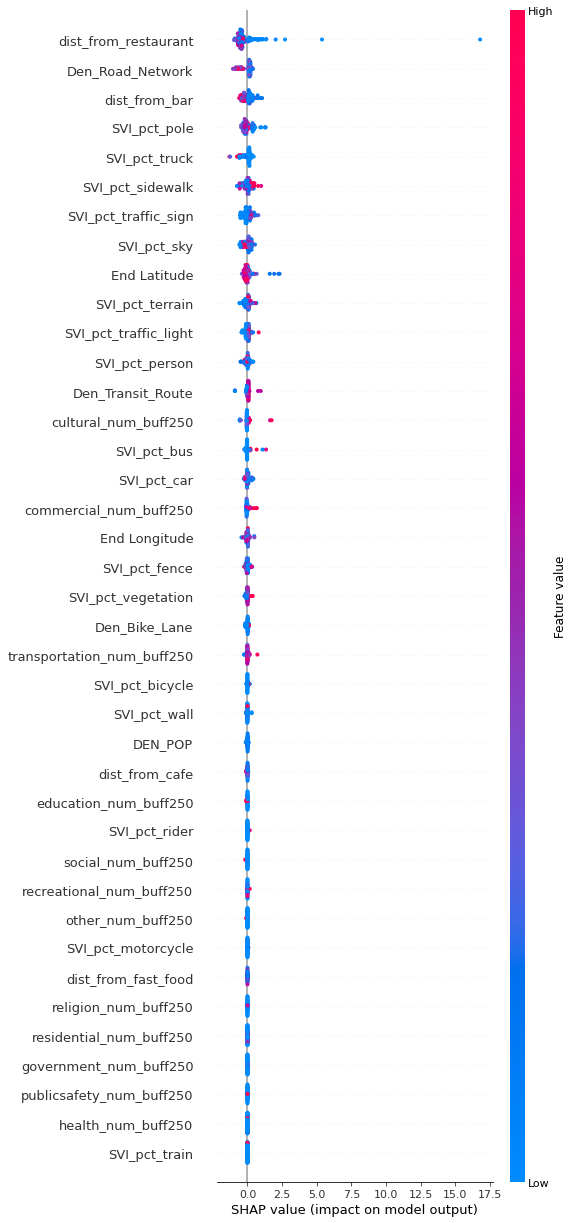

In [19]:
# Log Y
# Feature selection based on XGBoost

var_list = np.array(['DEN_POP', 'Den_Bike_Lane', 'End Latitude', 'End Longitude','Den_Transit_Route', 'Den_Road_Network', 
                     'other_num_buff250', 'residential_num_buff250', 'education_num_buff250', 'cultural_num_buff250', 
                     'recreational_num_buff250', 'social_num_buff250', 'commercial_num_buff250', 'government_num_buff250',
                     'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250', 'transportation_num_buff250',
                     'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant', 'dist_from_cafe',
                     'SVI_pct_sidewalk', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
                     'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
                     'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 'SVI_pct_rider',
                     'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

y = regression_model_input_D_final['ridership']
X = regression_model_input_D_final[var_list]

xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X, y)

# Predict on the test set
y_pred = xgb_model.predict(X)
print('MSE:', mean_squared_error(y, y_pred))
print('R2:', r2_score(y, y_pred))

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X)

# Visualize SHAP values
shap.summary_plot(shap_values, X, max_display=X.shape[1])

##### LAT, LON, CENSUS 

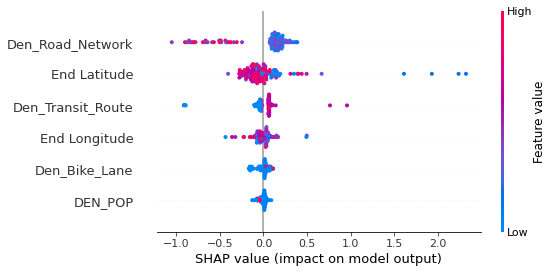

In [20]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 0:6], X.iloc[:, 0:6], max_display=X.shape[1])

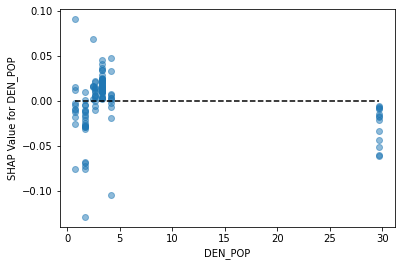

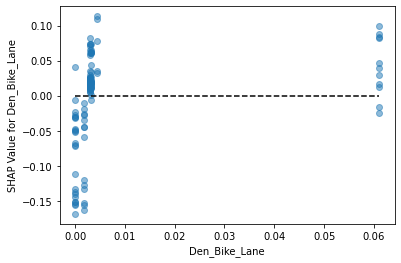

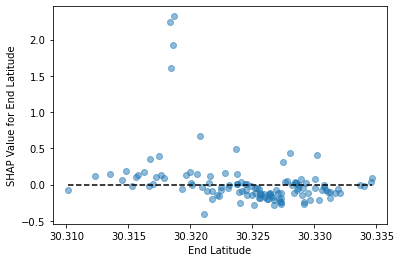

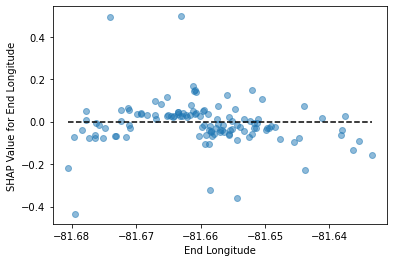

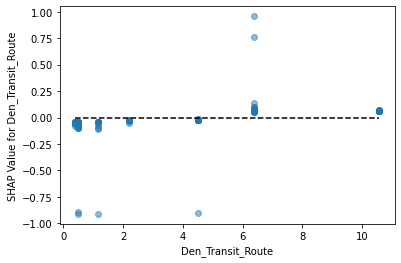

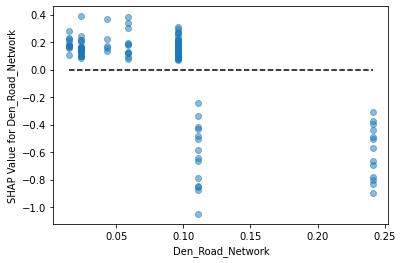

In [21]:
# Plot SHAP values of Feature 0 against the target
for i in range (6):
    feature_name = var_list[i] #
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

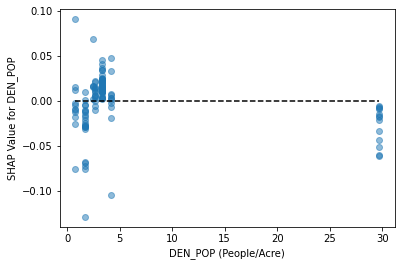

In [22]:
# Plot SHAP values of Feature 0 against the target
i = 0
feature_name = var_list[i] #
plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(People/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

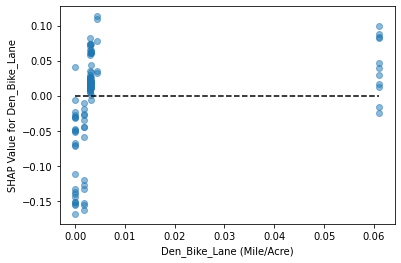

In [23]:
# Plot SHAP values of Feature 0 against the target
i = 1
feature_name = var_list[i] #
plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

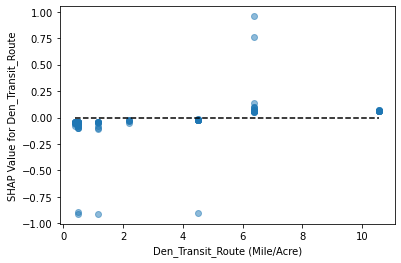

In [24]:
# Plot SHAP values of Feature 0 against the target
i = 4
feature_name = var_list[i] #
plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

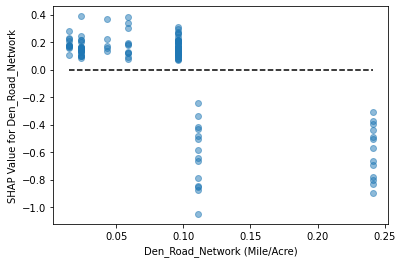

In [25]:
# Plot SHAP values of Feature 0 against the target
i = 5
feature_name = var_list[i] #
plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

### NUM POI

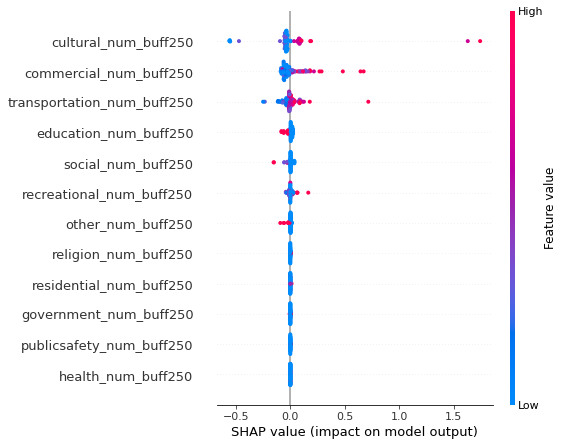

In [26]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 6:18], X.iloc[:, 6:18], max_display=X.shape[1])

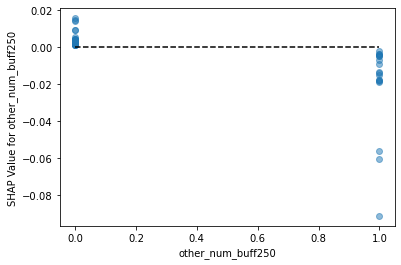

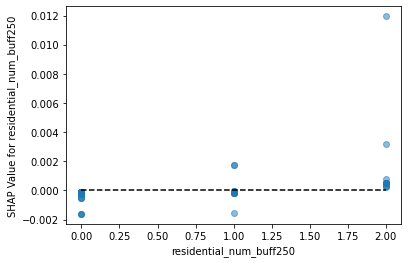

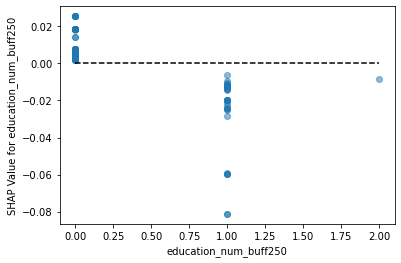

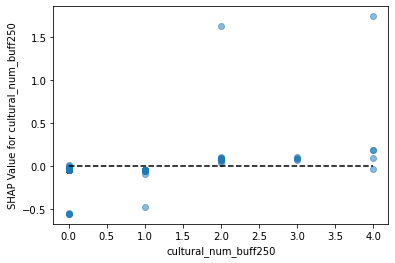

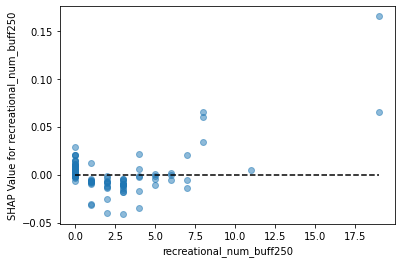

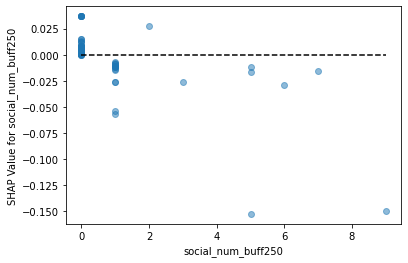

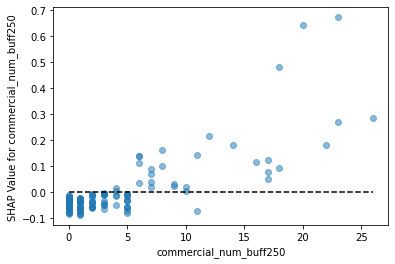

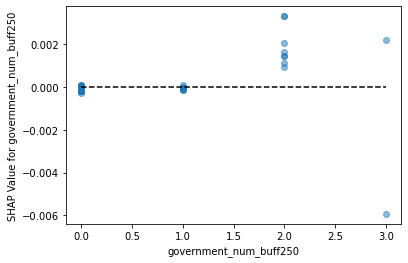

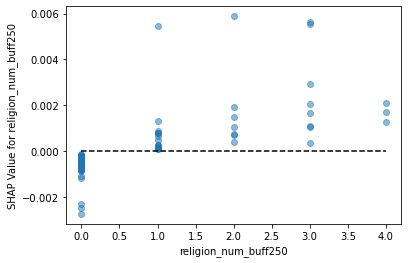

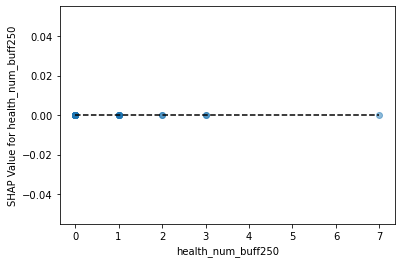

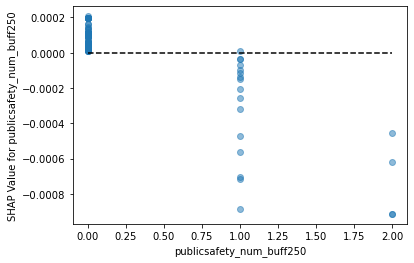

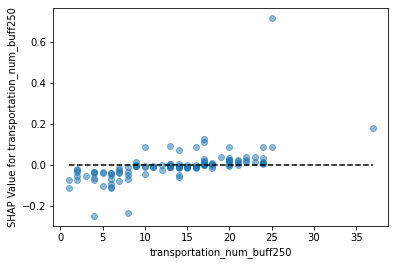

In [27]:
# Plot SHAP values of Feature 0 against the target
for i in range (6, 18):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

### DIST POI

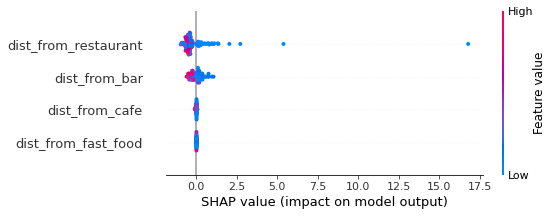

In [28]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 18:22], X.iloc[:, 18:22], max_display=X.shape[1])

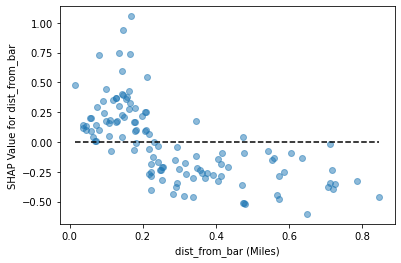

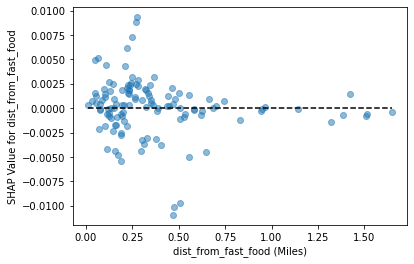

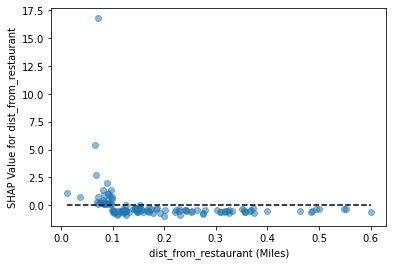

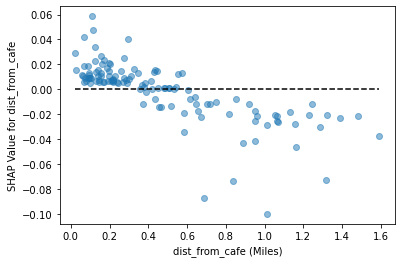

In [29]:
# Plot SHAP values of Feature 0 against the target
for i in range (18, 22):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name + ' ' + '(Miles)')
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

##### SVI

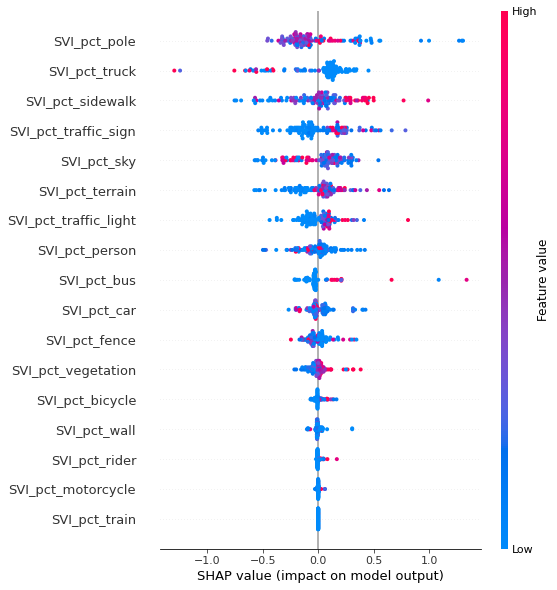

In [30]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 22:], X.iloc[:, 22:], max_display=X.shape[1])

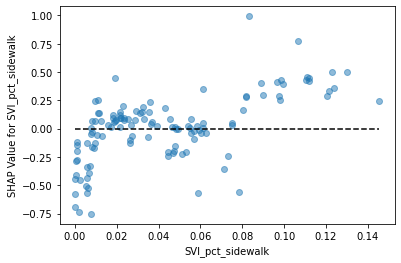

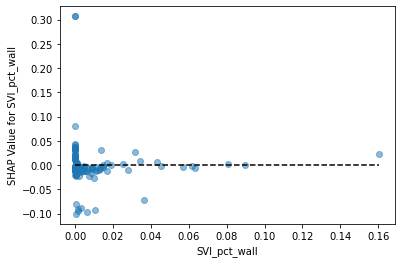

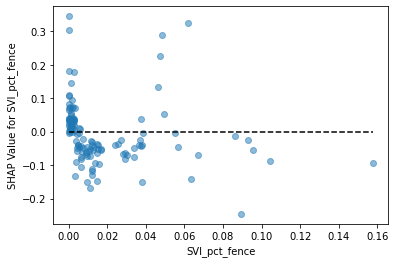

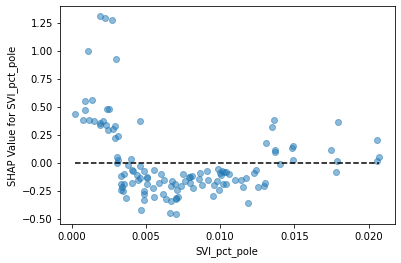

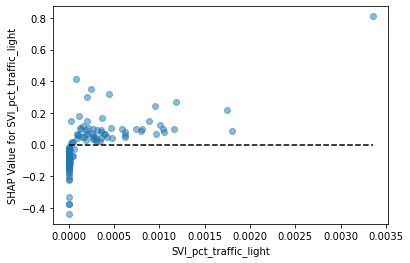

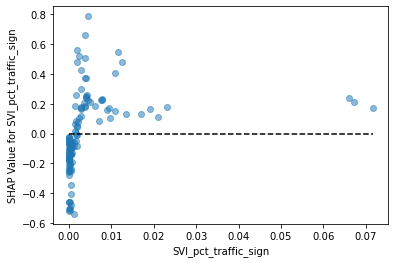

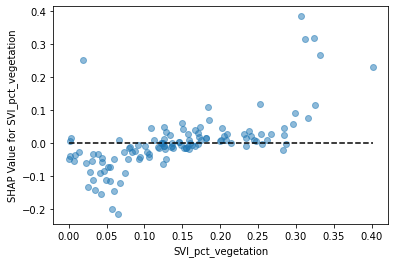

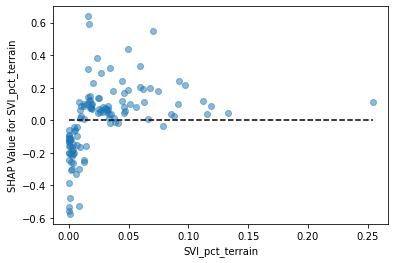

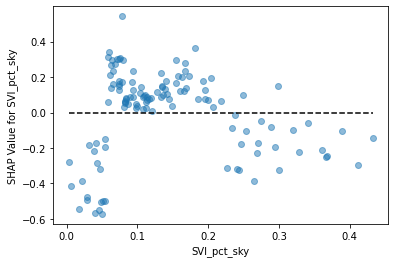

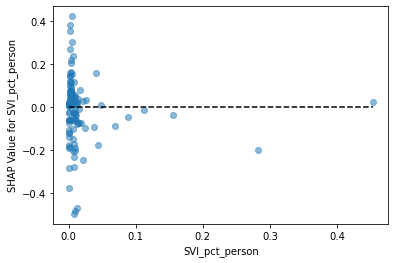

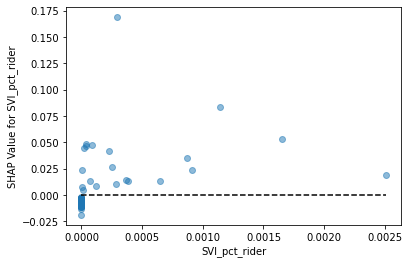

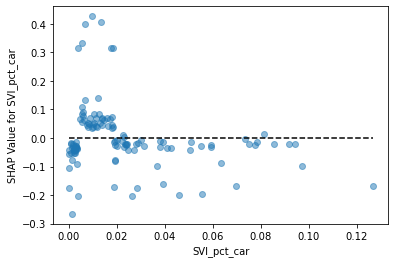

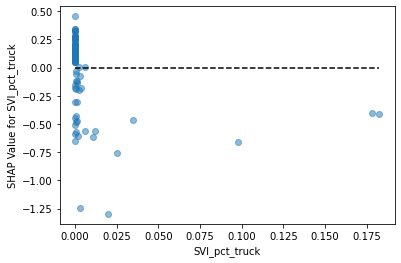

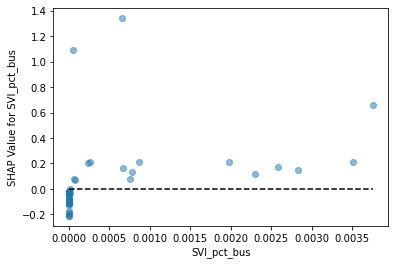

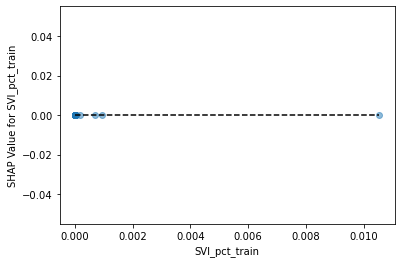

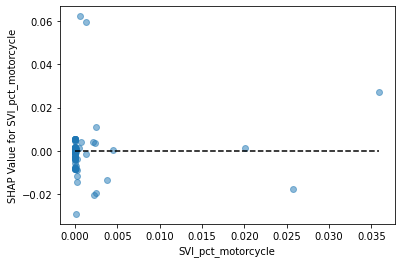

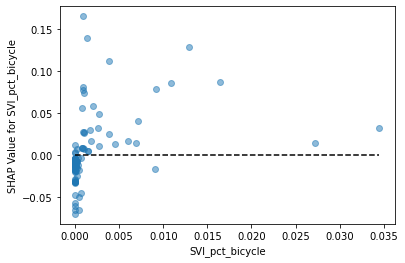

In [31]:
# Plot SHAP values of Feature 0 against the target
for i in range (22, len(var_list)):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_D_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_D_final[feature_name]), max(regression_model_input_D_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()